In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go

from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

import torch, os, warnings
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

cuda
/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
test = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')
sample_submission = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/sample_submission.csv')
print(df.shape, test.shape)

(12120, 6) (5195, 5)


In [3]:
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [4]:
print(df.iloc[0, df.columns.get_loc('premise')])
print(df.iloc[0, df.columns.get_loc('hypothesis')])

and these comments were considered in formulating the interim rules.
The rules developed in the interim were put together with these comments in mind.


In [5]:
label_counts = df.groupby(['language', 'label']).size().reset_index(name='count')
label_counts.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
language,Arabic,Arabic,Arabic,Bulgarian,Bulgarian,Bulgarian,Chinese,Chinese,Chinese,English,English,English,French,French,French,German,German,German,Greek,Greek,Greek,Hindi,Hindi,Hindi,Russian,Russian,Russian,Spanish,Spanish,Spanish,Swahili,Swahili,Swahili,Thai,Thai,Thai,Turkish,Turkish,Turkish,Urdu,Urdu,Urdu,Vietnamese,Vietnamese,Vietnamese
label,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2
count,124,129,148,123,111,108,140,146,125,2427,2166,2277,133,129,128,108,116,127,120,127,125,125,112,137,132,124,120,118,112,136,140,109,136,121,126,124,110,114,127,133,110,138,122,149,108


In [6]:
languages = label_counts['language'].unique()

for l in languages:
    print(f'{l} = {df[df.language == l]["lang_abv"].unique()}')

Arabic = ['ar']
Bulgarian = ['bg']
Chinese = ['zh']
English = ['en']
French = ['fr']
German = ['de']
Greek = ['el']
Hindi = ['hi']
Russian = ['ru']
Spanish = ['es']
Swahili = ['sw']
Thai = ['th']
Turkish = ['tr']
Urdu = ['ur']
Vietnamese = ['vi']


In [7]:
fig = sp.make_subplots(rows=3, cols=5, subplot_titles=languages)
colors = px.colors.qualitative.Pastel

row = 1
col = 1
color_index = 0

for language in languages:
    language_data = label_counts[label_counts['language'] == language]
    
    fig.add_trace(
                go.Bar(
                x=language_data['label'], y=language_data['count'], name=language,
                marker_color=colors[color_index % len(colors)]),     
                row=row,
                col=col)    
    col += 1
    if col > 5:
        col = 1
        row += 1
    color_index += 1

fig.update_layout(height=800, width=1200, title_text="Label counts for each language!")
fig.show()

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
tokenizer

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [9]:
premise_lengths = df['premise'].apply(lambda x: len(tokenizer.tokenize(x)))
hypothesis_lengths = df['hypothesis'].apply(lambda x: len(tokenizer.tokenize(x)))
total_lengths = premise_lengths + hypothesis_lengths
print(total_lengths.mean(), total_lengths.max(), total_lengths.median())

45.91881188118812 256 42.0


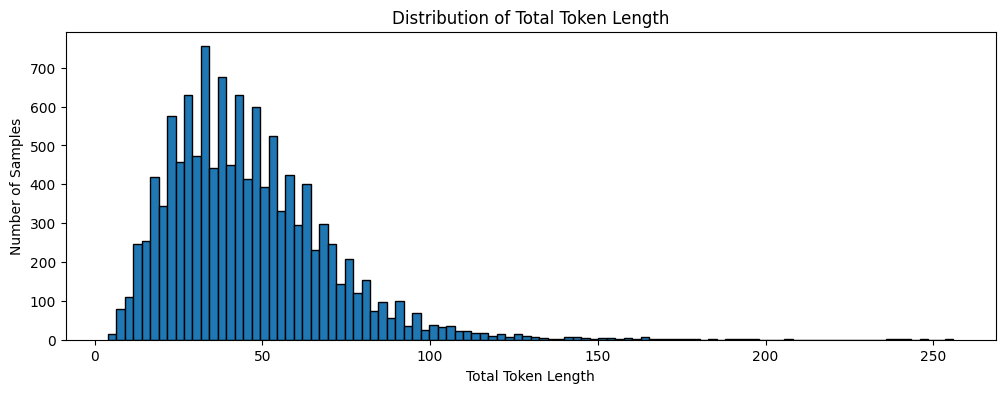

In [10]:
plt.figure(figsize=(12, 4))
plt.hist(total_lengths, bins=100, edgecolor='black')
plt.xlabel('Total Token Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Total Token Length')
plt.show()

In [11]:
max_length = 128
batch_size = 16

In [12]:
def tokenize_sentences(premise, hypothesis, tokenizer, max_length=max_length):
    return tokenizer.encode_plus(premise,
                                 hypothesis,
                                 add_special_tokens=True, # CLS, SEP
                                 max_length=max_length,
                                 padding='max_length',
                                 truncation=True, # Cuts token if max length is exceeded!
                                 truncation_strategy='longest_first',
                                 return_attention_mask=True, # Ignore padding 
                                 return_tensors='pt') # pt PyTorch

In [13]:
def dummy_tokenizer(premise, hypothesis, truncation, padding, max_length, return_tensors):
    return {'input_ids': torch.randint(0, 1000, (1, max_length)), 'attention_mask': torch.ones((1, max_length))}

grouped = df.groupby('language')

train_inputs, val_inputs = [], []
train_attention_masks, val_attention_masks = [], []
train_labels, val_labels = [], []

for name, group in grouped:
    tokenized = group.apply(lambda row: tokenize_sentences(row['premise'], row['hypothesis'], tokenizer, max_length=max_length), axis=1)
    input_ids = torch.stack([x['input_ids'].squeeze(0) for x in tokenized]).to(device)
    attention_masks = torch.stack([x['attention_mask'].squeeze(0) for x in tokenized]).to(device)
    labels = torch.tensor(group['label'].values).to(device)

    train_inputs_split, val_inputs_split, train_attention_masks_split, val_attention_masks_split, train_labels_split, val_labels_split = train_test_split(
        input_ids, attention_masks, labels, test_size=0.2, random_state=42)

    train_inputs.append(train_inputs_split)
    val_inputs.append(val_inputs_split)
    train_attention_masks.append(train_attention_masks_split)
    val_attention_masks.append(val_attention_masks_split)
    train_labels.append(train_labels_split)
    val_labels.append(val_labels_split)

train_inputs = torch.cat(train_inputs, dim=0)
val_inputs = torch.cat(val_inputs, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
train_labels = torch.cat(train_labels, dim=0)
val_labels = torch.cat(val_labels, dim=0)

train_dataset = TensorDataset(train_inputs, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_attention_masks, val_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=batch_size)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [14]:
# tokenized = df.apply(lambda row: tokenize_sentences(row['premise'], row['hypothesis'], tokenizer, max_length=max_length), axis=1)
# batch_size = 16

# input_ids = torch.stack([x['input_ids'].squeeze(0) for x in tokenized]).to(device)
# attention_masks = torch.stack([x['attention_mask'].squeeze(0) for x in tokenized]).to(device)
# labels = torch.tensor(df['label'].values).to(device)

# #---------------------------------------------------------------------------------

# dataset = TensorDataset(input_ids, attention_masks, labels)
# dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

# train_inputs, val_inputs, train_attention_masks, val_attention_masks, train_labels, val_labels = train_test_split(
#     input_ids, attention_masks, labels, test_size=0.2, random_state=42)

# train_dataset = TensorDataset(train_inputs, train_attention_masks, train_labels)
# val_dataset = TensorDataset(val_inputs, val_attention_masks, val_labels)

# train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
# val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# print(input_ids.shape)
# print(attention_masks.shape)
# print(labels.shape)

# #---------------------------------------------------------------------------------

# test_tokenized = test.apply(lambda row: tokenize_sentences(row['premise'], row['hypothesis'], tokenizer, max_length=max_length), axis=1)
# test_input_ids = torch.stack([x['input_ids'].squeeze(0) for x in test_tokenized]).to(device)
# test_attention_masks = torch.stack([x['attention_mask'].squeeze(0) for x in test_tokenized]).to(device)

# test_dataset = TensorDataset(test_input_ids, test_attention_masks)
# test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

In [15]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [16]:
def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs=2, patience=2):
    
    train_losses = []
    val_losses = []
    accuracies = []
    
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            
            optimizer.zero_grad()
            input_ids, attention_masks, labels = batch
            outputs = model(input_ids, attention_mask=attention_masks)
            loss = criterion(outputs.logits, labels)
            loss += 0.01 * torch.sum(model.bert.embeddings.word_embeddings.weight ** 2)  # L2 regularization
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f'Epoch {epoch+1} Training Loss: {avg_train_loss}')

        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            
            for batch in val_dataloader:
                
                input_ids, attention_masks, labels = batch
                outputs = model(input_ids, attention_mask=attention_masks)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_dataloader)
        accuracy = accuracy_score(all_labels, all_preds)
        
        val_losses.append(avg_val_loss)
        accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1} Validation Loss: {avg_val_loss}')
        print(f'Epoch {epoch+1} Accuracy: {accuracy * 100:.2f}%')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping triggered, no improvement for last {patience} epochs.')
            break

    return model, train_losses, val_losses, accuracies

In [17]:
model, train_losses, val_losses, accuracies = train_and_evaluate(
    model, train_dataloader, val_dataloader, optimizer, criterion, epochs=5, patience=3)

Epoch 1 Training Loss: 1660.7169060533984
Epoch 1 Validation Loss: 0.8824161659730109
Epoch 1 Accuracy: 61.23%
Epoch 2 Training Loss: 1120.7210087036535
Epoch 2 Validation Loss: 0.8232434699802023
Epoch 2 Accuracy: 64.39%
Epoch 3 Training Loss: 759.7673451640818
Epoch 3 Validation Loss: 0.8923799382816804
Epoch 3 Accuracy: 64.56%
Epoch 4 Training Loss: 514.1295714929159
Epoch 4 Validation Loss: 1.119911185416736
Epoch 4 Accuracy: 63.16%
Epoch 5 Training Loss: 345.83784857520175
Epoch 5 Validation Loss: 1.284557896421144
Epoch 5 Accuracy: 63.65%
Early stopping triggered, no improvement for last 3 epochs.


In [18]:
print(train_losses)
print(val_losses)
print(accuracies)

[1660.7169060533984, 1120.7210087036535, 759.7673451640818, 514.1295714929159, 345.83784857520175]
[0.8824161659730109, 0.8232434699802023, 0.8923799382816804, 1.119911185416736, 1.284557896421144]
[0.6122532894736842, 0.6439144736842105, 0.6455592105263158, 0.631578947368421, 0.6365131578947368]


In [19]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# all_train_losses = []
# all_val_losses = []
# all_accuracies = []

# fold = 0
# for train_index, val_index in kf.split(df):
#     fold += 1
#     print(f"Fold {fold}")
    
#     train = df.iloc[train_index]
#     val = df.iloc[val_index]
    
#     train_tokenized = train.apply(lambda row: tokenize_sentences(row['premise'], row['hypothesis'], tokenizer), axis=1)
#     val_tokenized = val.apply(lambda row: tokenize_sentences(row['premise'], row['hypothesis'], tokenizer), axis=1)
    
#     train_input_ids = torch.stack([x['input_ids'].squeeze(0) for x in train_tokenized]).to(device)
#     train_attention_masks = torch.stack([x['attention_mask'].squeeze(0) for x in train_tokenized]).to(device)
#     train_labels = torch.tensor(train['label'].values).to(device)
    
#     val_input_ids = torch.stack([x['input_ids'].squeeze(0) for x in val_tokenized]).to(device)
#     val_attention_masks = torch.stack([x['attention_mask'].squeeze(0) for x in val_tokenized]).to(device)
#     val_labels = torch.tensor(val['label'].values).to(device)
    
#     train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
#     val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
    
#     train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
#     val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
    
#     model, train_losses, val_losses, accuracies = train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs=5, patience=3)
    
#     all_train_losses.append(train_losses)
#     all_val_losses.append(val_losses)
#     all_accuracies.append(accuracies)

# -----------------------------------------------------------------------------------------

# avg_train_losses = np.mean(all_train_losses, axis=0)
# avg_val_losses = np.mean(all_val_losses, axis=0)
# avg_accuracies = np.mean(all_accuracies, axis=0)

# print(avg_train_losses)
# print(avg_val_losses)
# print(avg_accuracies)

# fold_train_losses = [np.mean(train_loss) for train_loss in all_train_losses]
# fold_val_losses = [np.mean(val_loss) for val_loss in all_val_losses]
# fold_accuracies = [np.mean(accuracy) for accuracy in all_accuracies]

# print(fold_train_losses)
# print(fold_val_losses)
# print(fold_accuracies)

# for i in range(len(fold_train_losses)):
#     print(f"Fold {i+1} - Avg Train Loss: {fold_train_losses[i]}, Avg Val Loss: {fold_val_losses[i]}, Avg Accuracy: {fold_accuracies[i]}")

# -----------------------------------------------------------------------------------------

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(range(1, len(fold_train_losses) + 1), fold_train_losses, marker='o', label='Train Loss')
# plt.plot(range(1, len(fold_val_losses) + 1), fold_val_losses, marker='o', label='Validation Loss')
# plt.xlabel('Fold')
# plt.ylabel('Loss')
# plt.title('Average Loss for Each Fold')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(range(1, len(fold_accuracies) + 1), [acc * 100 for acc in fold_accuracies], marker='o', label='Validation Accuracy')
# plt.xlabel('Fold')
# plt.ylabel('Accuracy (%)')
# plt.title('Average Accuracy for Each Fold')
# plt.legend()

# plt.tight_layout()
# plt.show()

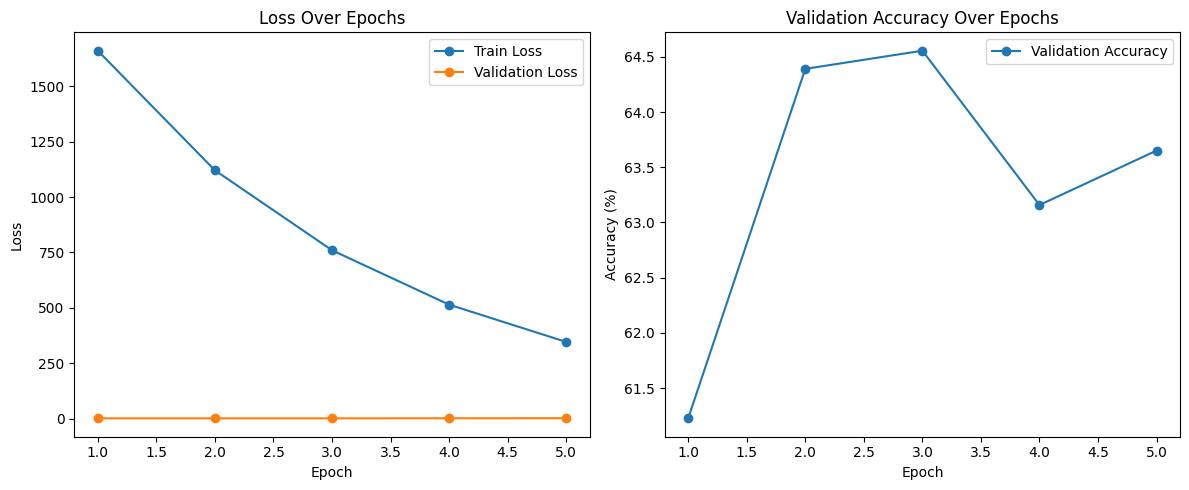

In [20]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, marker='o', label='Train Loss')
plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in accuracies], marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Validation losses are almost 0 especially compared to Training Losses because of regularization penalty.

In [21]:
test_tokenized = test.apply(lambda row: tokenize_sentences(row['premise'], row['hypothesis'], tokenizer, max_length=max_length), axis=1)
test_input_ids = torch.stack([x['input_ids'].squeeze(0) for x in test_tokenized]).to(device)
test_attention_masks = torch.stack([x['attention_mask'].squeeze(0) for x in test_tokenized]).to(device)

test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [22]:
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_masks = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        logits = torch.softmax(logits, dim=1)
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())

test['prediction'] = predictions
test.to_csv('submission.csv', columns=['id', 'prediction'], index=False)

In [23]:
submission = pd.read_csv('submission.csv')
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,2
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1
